<a href="https://colab.research.google.com/github/mutouyu1124/Citi-Bikeshare-Time-Series-Analysis/blob/master/City_Bank_Bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
os.chdir('./gdrive/My Drive/Colab Notebooks/DL/TS/data/')
!ls

AirPassengers.csv  home_dat_20160918_20170604.pkl  sandp500


In [0]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [0]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


class AutoregressiveTransformer(BaseEstimator, TransformerMixin):


    def __init__(self, num_lags=5, pred_stride=1):
        super().__init__()
        self.num_lags = num_lags
        self.pred_stride = pred_stride

    def fit(self, X, y=None):
        self._final_points = X[-self.pred_stride:, 0]
        return self

    def transform(self, X, y=None):

        X_trans = []
        for i in range(self.num_lags, 0, -1):
            X_trans.append(
                [X[self.num_lags - i:-(i + self.pred_stride - 1), 0]])

        X_trans = np.vstack(X_trans).T

        X_trans = self._fill_missing(X_trans)
        return X_trans

    def _fill_missing(self, X):
        missing_vals = np.zeros((self.num_lags + self.pred_stride - 1,
                                 self.num_lags),
                                dtype=X.dtype)
        missing_vals[:] = np.nan
        return np.vstack((missing_vals, X))

    def inverse_transform(self, X):
        return np.concatenate((
            X[self.num_lags + self.pred_stride - 1, :], # Slice along first window
            X[self.num_lags + self.pred_stride:, -1], # Then grab all single-lag up to last one
            np.atleast_1d(self._final_points))
        )[:, np.newaxis]


class SeasonalTransformer(AutoregressiveTransformer):

    def __init__(self, seasonal_period=1, pred_stride=1):
        pred_stride = seasonal_period + pred_stride - 1
        super().__init__(num_lags=1, pred_stride=pred_stride)


class IntegratedTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, num_lags=1, pred_stride=1):
        super().__init__()
        self.num_lags = num_lags
        self.pred_stride = pred_stride
        self.ar1 = AutoregressiveTransformer(
            num_lags=self.num_lags,
            pred_stride=self.pred_stride)
        self.ar2 = AutoregressiveTransformer(
            num_lags=self.num_lags,
            pred_stride=1 + self.pred_stride)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        Xt1 = self.ar1.transform(X)
        Xt2 = self.ar2.transform(X)
        return Xt1 - Xt2


class TrendTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.expand_dims(np.arange(X.shape[0]), axis=1)


class FourierTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, period=10, max_order=10, step_size=1):
        super().__init__()
        self.period = period
        self.max_order = max_order
        self.step_size = step_size

    def fit(self, X, y=None):
        return self

    def _get_trig_args(self, X):
        trig_args = ((2 * np.pi / self.period)
                     * np.arange(1, self.max_order + 1, self.step_size))
        time = np.arange(X.shape[0])
        trig_args = trig_args[np.newaxis, :] * time[:, np.newaxis]
        return trig_args

    def transform(self, X, y=None):
        trig_args = self._get_trig_args(X)
        cos = np.cos(trig_args)
        sin = np.sin(trig_args)
        fourier_terms = np.hstack((cos, sin))
        return fourier_terms

import numpy as np
from numpy.lib.stride_tricks import as_strided
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

def expand_dim_if_needed(arr):
    if arr.ndim == 1:
        return np.expand_dims(arr, axis=1)
    return arr

    
class ReversibleImputer(BaseEstimator, TransformerMixin):

    needs_refit = True

    def __init__(self, y_only=False):
        super().__init__()
        self.y_only = y_only
    
    def fit(self, X, y=None):
        mask = np.isnan(X)
        self._missing_idxs = np.where(mask)
        self._mean = X[~mask].mean()
        return self
    
    def transform(self, X, y=None, refit=False):
        if refit:
            self.fit(X, y=y)

        check_is_fitted(self, '_mean')
        X[self._missing_idxs] = self._mean
        return X
    
    def inverse_transform(self, X):
        X[self._missing_idxs] = np.nan
        return X


class DifferenceTransformer(BaseEstimator, TransformerMixin):

    needs_refit = True

    def __init__(self, period=1):
        super().__init__()
        self.period = period

    def fit(self, X, y=None):
        missing = np.where(np.isnan(X))[0]

        if len(missing) > 0:
            self._missing_idx_start = np.max(missing) + 1
        else:
            self._missing_idx_start = 0

        self._missing_idx_end = self._missing_idx_start + self.period
        self._missing_vals = X[self._missing_idx_start:self._missing_idx_end, :]
        return self

    def transform(self, X, y=None, refit=False):
        if refit:
            self.fit(X, y=y)

        check_is_fitted(self, '_missing_idx_start')

        X_shift = np.roll(X, self.period, axis=0)
        X_trans = X - X_shift
        X_trans[:self._missing_idx_end, :] = np.nan

        return X_trans

    def inverse_transform(self, X):
        # TODO: Figure out why I have to make a copy here
        X = X.copy()

        # Fill in the missing values
        X[self._missing_idx_start:self._missing_idx_end, :] = self._missing_vals
        X_inv = X[self._missing_idx_start:, :]

        # Take stock
        period_rem = np.remainder(len(X_inv), self.period)
        stride_shape = [self.period,
                        int(np.floor(len(X_inv) / self.period) + period_rem)]
        stride = X.strides[0]

        # Clusterfuck
        inv = (as_strided(X_inv,
                          shape=stride_shape,
                          strides=[stride, stride * self.period])
               .cumsum(axis=1)
               .reshape(stride_shape[0] * stride_shape[1], order='F')
               [:len(X_inv)])[:, np.newaxis]

        return np.vstack((X[:self._missing_idx_start, :], inv))


class LogTransformer(BaseEstimator, TransformerMixin):

    needs_refit = False

    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None, refit=False):
        with np.errstate(divide='raise', invalid='raise'):
            try:
                Xt = np.log(X)
            except FloatingPointError:
                raise ValueError('X cannot have negative or zero values')
        return Xt

    def inverse_transform(self, X):
        return np.exp(X)


class HorizonTransformer(BaseEstimator, TransformerMixin):

    needs_refit = True
    y_only = True

    def __init__(self, horizon=2):
        super().__init__()
        if horizon < 2:
            raise ValueError('horizon must be greater than 1')
        self.horizon = horizon
        self.autoregressive_transformer = AutoregressiveTransformer(
            num_lags=self.horizon,
            pred_stride=1
        )

    def fit(self, X, y=None):
        self.autoregressive_transformer.fit(expand_dim_if_needed(X))
        return self

    def transform(self, X, y=None, refit=False):
        X = expand_dim_if_needed(X)
        if refit:
            self.autoregressive_transformer.fit(X)
        Xt = self.autoregressive_transformer.transform(X)
        # Need to move beginning of Xt to the end.
        Xt = np.vstack((Xt[self.horizon:, :], Xt[:self.horizon, :]))
        # TODO: replace beginning with nans?
        return Xt

    def inverse_transform(self, X, y=None):
        Xt = np.vstack((X[-self.horizon:, :], X[:-self.horizon, :]))
        return self.autoregressive_transformer.inverse_transform(Xt)

import numpy as np
from sklearn.base import clone
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.utils.validation import check_memory

def _fit_transform_one(transformer, weight, X, y,
                       **fit_params):
    if hasattr(transformer, 'fit_transform'):
        res = transformer.fit_transform(X, y, **fit_params)
    else:
        res = transformer.fit(X, y, **fit_params).transform(X)
    # if we have a weight for this transformer, multiply output
    if weight is None:
        return res, transformer
    return res * weight, transformer


def _needs_refit(transform):

    return hasattr(transform, 'needs_refit') and transform.needs_refit


class _BasePipeline(Pipeline):
    
    def __init__(self, steps, memory=None):
        super().__init__(steps, memory=memory)
        self._skits_validation()

    def _skits_validation(self):
        feature_extractors_found = False
        for name, step in self.steps:
            if name.startswith('pre') and feature_extractors_found:
                raise ValueError('All preprocessors must come before '
                                 'feature extractors')
            elif isinstance(step, FeatureUnion):
                feature_extractors_found = True

    def _transform(self, X, refit=False):
        Xt = X
        for name, transform in self.steps:
            if transform is not None:
                if _needs_refit(transform):
                    Xt = transform.transform(Xt, refit=True)
                else:
                    Xt = transform.transform(Xt)
        return Xt


class ForecasterPipeline(_BasePipeline):

    def __init__(self, steps, memory=None):
        super().__init__(steps, memory=memory)

    def _fit(self, X, y=None, **fit_params):
        """
        All of this stolen from scikit-learn except for
        "if name.startsiwth('pre_')..." at the bottom
        """
        # shallow copy of steps - this should really be steps_
        self.steps = list(self.steps)
        self._validate_steps()
        # Setup the memory
        memory = check_memory(self.memory)

        fit_transform_one_cached = memory.cache(_fit_transform_one)

        fit_params_steps = dict((name, {}) for name, step in self.steps
                                if step is not None)
        for pname, pval in fit_params.items():
            step, param = pname.split('__', 1)
            fit_params_steps[step][param] = pval
        Xt = X
        for step_idx, (name, transformer) in enumerate(self.steps[:-1]):
            if transformer is None:
                pass
            else:
                # For the HorizonTransformer right now.
                y_only = getattr(transformer, 'y_only', False)
                _Xt = y.copy() if y_only else Xt

                if hasattr(memory, 'cachedir') and memory.cachedir is None:
                    # we do not clone when caching is disabled to preserve
                    # backward compatibility
                    cloned_transformer = transformer
                else:
                    cloned_transformer = clone(transformer)
                # Fit or load from cache the current transfomer
                _Xt, fitted_transformer = fit_transform_one_cached(
                    cloned_transformer, None, _Xt, y,
                    **fit_params_steps[name])
                # Replace the transformer of the step with the fitted
                # transformer. This is necessary when loading the transformer
                # from the cache.
                self.steps[step_idx] = (name, fitted_transformer)

                if y_only:
                    y = _Xt
                else:
                    Xt = _Xt

                # This is so ugly :(
                if name.startswith('pre_') and not y_only:
                    y = transformer.transform(y[:, np.newaxis]).squeeze().copy()

        if self._final_estimator is None:
            return Xt, {}

        return Xt, fit_params_steps[self.steps[-1][0]], y

    def fit(self, X, y=None, start_idx=0, end_idx=-1,
            **fit_params):
        """
        Stolen from scikit-learn
        Fit the model
        Fit all the transforms one after the other and transform the
        data, then fit the transformed data using the final estimator.
        Parameters
        ----------
        X : iterable
            Training data. Must fulfill input requirements of first step of the
            pipeline.
        y : iterable, default=None
            Training targets. Must fulfill label requirements for all steps of
            the pipeline.
        **fit_params : dict of string -> object
            Parameters passed to the ``fit`` method of each step, where
            each parameter name is prefixed such that parameter ``p`` for step
            ``s`` has key ``s__p``.
        Returns
        -------
        self : Pipeline
            This estimator
        """
        Xt, fit_params, y = self._fit(X, y, **fit_params)
        if self._final_estimator is not None:
            self._final_estimator.fit(Xt[start_idx:, :], y[start_idx:],
                                      **fit_params)

        return self

    def fit_transform(self, X, y=None, **fit_params):
        """
        Stolen from scikit-learn
        Fit the model and transform with the final estimator
        Fits all the transforms one after the other and transforms the
        data, then uses fit_transform on transformed data with the final
        estimator.
        Parameters
        ----------
        X : iterable
            Training data. Must fulfill input requirements of first step of the
            pipeline.
        y : iterable, default=None
            Training targets. Must fulfill label requirements for all steps of
            the pipeline.
        **fit_params : dict of string -> object
            Parameters passed to the ``fit`` method of each step, where
            each parameter name is prefixed such that parameter ``p`` for step
            ``s`` has key ``s__p``.
        Returns
        -------
        Xt : array-like, shape = [n_samples, n_transformed_features]
            Transformed samples
        """
        last_step = self._final_estimator
        Xt, fit_params, y = self._fit(X, y, **fit_params)
        if hasattr(last_step, 'fit_transform'):
            return last_step.fit_transform(Xt, y, **fit_params)
        elif last_step is None:
            return Xt
        else:
            return last_step.fit(Xt, y, **fit_params).transform(Xt)

    def inverse_transform(self, X, y=None):
        Xt = X
        for name, step in self.steps[-2::-1]:
            if name.startswith('pre_') and not getattr(step, 'y_only', False):
                if Xt.ndim == 1:
                    Xt = Xt[:, np.newaxis]
                Xt = step.inverse_transform(Xt)

        return Xt

    @if_delegate_has_method(delegate='_final_estimator')
    def predict(self, X, to_scale=False, refit=True, start_idx=0):
        """
        NOTE: Most of this method stolen from scikit-learn
        Apply transforms to the data, and predict with the final estimator
        Parameters
        ----------
        X : iterable
            Data to predict on. Must fulfill input requirements of first step
            of the pipeline.
        Returns
        -------
        y_pred : array-like
        """
        Xt = X.copy()
        for name, transform in self.steps[:-1]:
            if transform is not None:
                y_only = getattr(transform, 'y_only', False)
                if y_only:
                    continue
                if _needs_refit(transform) and refit:
                    Xt = transform.transform(Xt, refit=True)
                else:
                    Xt = transform.transform(Xt)

        prediction = self.steps[-1][-1].predict(Xt)
        if to_scale:
            prediction = expand_dim_if_needed(prediction)
            for idx in range(prediction.shape[1]):
                prediction[:, [idx]] = self.inverse_transform(prediction[:, [idx]])
        return prediction[start_idx:].squeeze()

    def forecast(self, X, start_idx, trans_window=None):
        """
        Run out of sample predictions. That is, predict on X up until start_idx,
        use the predictions to concatenate data onto X, and continue predicting
        for the full length of X.
        Parameters
        ----------
        X : iterable
            Data to predict on. Must fulfill input requirements of first step
            of the pipeline.
        start_idx : int
            Index of X on which to start forecasting.
        trans_window : int (optional)
            Number of previous values of X necessary for transforming X into
            features. Set this to speed up forecasting such that you do not have
            to re-transform X for every prediction step of forecasting.
        Returns
        -------
        """
        # TODO:
        # Assert the model is fitted
        # Assert start_idx is > num_lags + pred_stride. This one can cause
        # everything to turn nan.

        if trans_window is not None:
            assert start_idx > trans_window, (
                'start_idx must be > than trans_window')

        # Run the prediction up until the starting index.
        # Note: We have to expand dims for multioutput results.
        X_init = expand_dim_if_needed(
            self.predict(X[:start_idx], to_scale=True, refit=True)
        )[:, 0]

        # Create the final prediction matrix and fill in all predictions up to
        # the starting index.
        X_total = np.empty((X.shape[0], 1), dtype=np.float32)
        X_total[:X_init.shape[0], 0] = X_init

        # For each out of sample point (aka >= start_idx)
        for idx in range(start_idx, len(X)):

            # Predict the next point
            offset = trans_window or idx
            next_point = expand_dim_if_needed(
                self.predict(X_total[idx - offset:idx], to_scale=True,
                             refit=False)
            )[-1, 0]

            # And add that point to the total prediction matrix.
            X_total[idx, :] = next_point

        return X_total


class ClassifierPipeline(_BasePipeline):

    def __init__(self, steps, memory=None):
        super().__init__(steps, memory=memory)

    @if_delegate_has_method(delegate='_final_estimator')
    def predict(self, X, refit=True):
        """
        NOTE: Most of this method stolen from scikit-learn.
        Only difference is that I want to squeeze the output.
        Apply transforms to the data, and predict with the final estimator
        Parameters
        ----------
        X : iterable
            Data to predict on. Must fulfill input requirements of first step
            of the pipeline.
        Returns
        -------
        y_pred : array-like
        """
        Xt = X
        for name, transform in self.steps[:-1]:
            if transform is not None:
                if _needs_refit(transform) and refit:
                    Xt = transform.transform(Xt, refit=True)
                else:
                    Xt = transform.transform(Xt)

        prediction = self.steps[-1][-1].predict(Xt)
        return prediction.squeeze()

# Data Preprocess and check stationarity

In [5]:
df = pd.read_pickle('home_dat_20160918_20170604.pkl')
df.set_index('last_communication_time', inplace=True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.head()

,execution_time,available_bikes,available_docks,id,lat,lon,st_address,station_name,status_key,status_value,test_station,total_docks
last_communication_time,,,,,,,,,,,,
2016-09-18 16:58:36,2016-09-18 16:59:51,4,43,496,40.737262,-73.99239,E 16 St & 5 Ave,E 16 St & 5 Ave,1,In Service,f,47
2016-09-18 16:58:36,2016-09-18 17:01:47,4,43,496,40.737262,-73.99239,E 16 St & 5 Ave,E 16 St & 5 Ave,1,In Service,f,47
2016-09-18 17:02:29,2016-09-18 17:03:42,7,40,496,40.737262,-73.99239,E 16 St & 5 Ave,E 16 St & 5 Ave,1,In Service,f,47
2016-09-18 17:02:29,2016-09-18 17:05:48,7,40,496,40.737262,-73.99239,E 16 St & 5 Ave,E 16 St & 5 Ave,1,In Service,f,47
2016-09-18 17:07:06,2016-09-18 17:07:44,7,40,496,40.737262,-73.99239,E 16 St & 5 Ave,E 16 St & 5 Ave,1,In Service,f,47


## Plot time series data

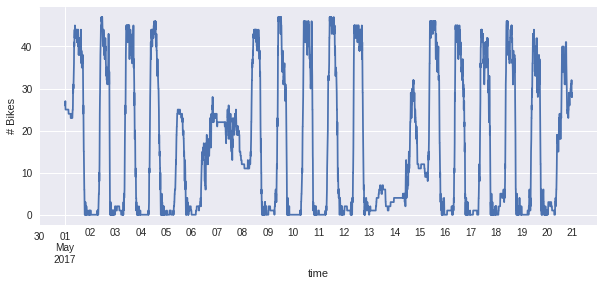

In [6]:
# Pick out our time series object
# and fix it to a 5-min sampling period
y = df.available_bikes
y.index.name = 'time'
y = y.resample('5T').last()
y = y.fillna(method='ffill')
y.loc['2017-05-01':'2017-05-20'].plot(figsize=(10, 4));
plt.ylabel('# Bikes');

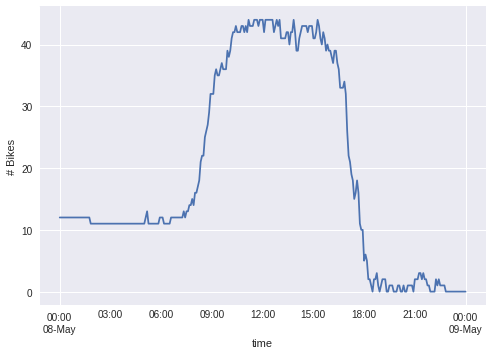

In [7]:
y.loc['2017-05-08 00:00:00':'2017-05-09 00:00:00'].plot();
plt.ylabel('# Bikes');

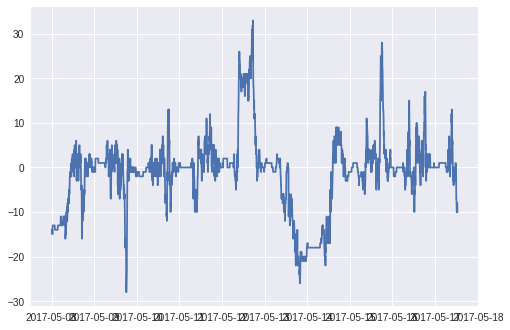

In [8]:
y_sample = y.loc['2017-05-01':'2017-05-20']
period_minutes = 5
samples_per_hour = int(60 / period_minutes)
samples_per_day = int(24 * samples_per_hour)
samples_per_week = int(7 * samples_per_day)
y_s = y.loc['2017-05-01':'2017-05-20']-y.loc['2017-05-01':'2017-05-20'].shift(samples_per_week)
plt.plot(y_s[:-1000])

## Plot ACF and PACF to check stationarity

In [0]:
def plot_multi_acf(data, lags, titles, ylim=None, partial=False):
    num_plots = len(lags)
    fig, ax = plt.subplots(len(lags), 1, figsize=(10, 3 * num_plots));
    if num_plots == 1:
        ax = [ax]
    acf_func = smt.graphics.plot_pacf if partial else smt.graphics.plot_acf
    for idx, (lag, title) in enumerate(zip(lags, titles)):
        fig = acf_func(data, lags=lag, ax=ax[idx], title=title);
        if ylim is not None:
            ax[idx].set_ylim(ylim);
    
    fig.tight_layout();

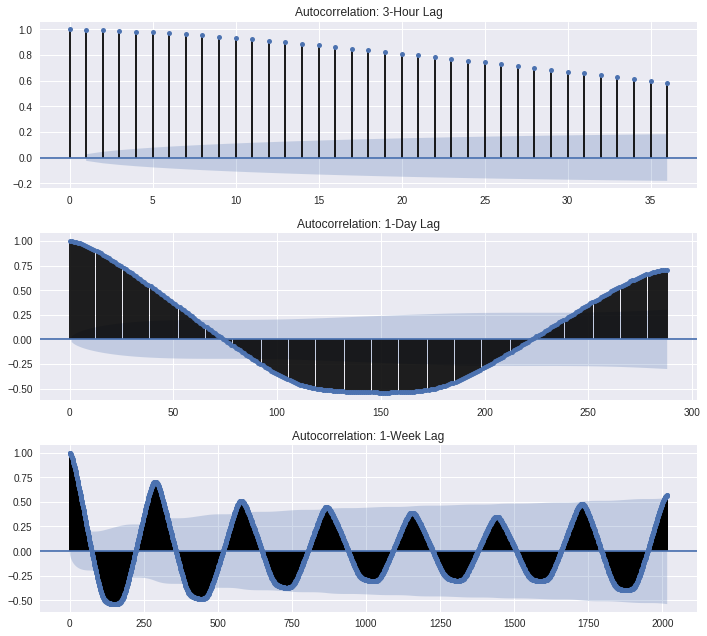

In [312]:
period_minutes = 5
samples_per_hour = int(60 / period_minutes)
samples_per_day = int(24 * samples_per_hour)
samples_per_week = int(7 * samples_per_day)
    
lags = [3 * samples_per_hour, samples_per_day, samples_per_week]
titles= ['Autocorrelation: 3-Hour Lag',
         'Autocorrelation: 1-Day Lag',
         'Autocorrelation: 1-Week Lag']

plot_multi_acf(y_sample, lags, titles)

# Transform time series to stationary by differences and seasonal differences

In [9]:
pipeline = ForecasterPipeline([
    ('pre_differencer', DifferenceTransformer(period=samples_per_week)),
    ('pre_diff_imputer', ReversibleImputer()),
    ('pre_day_differencer', DifferenceTransformer(period=1)),
    ('pre_day_diff_imputer', ReversibleImputer()),
    ('pre_day_differencer1', DifferenceTransformer(period=144)),
    ('pre_day_diff_imputer1', ReversibleImputer()),
    ('pre_scaler', StandardScaler())
])

X = y_sample.copy()[:, np.newaxis]

Xt = pipeline.fit_transform(X, y_sample)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:341: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.


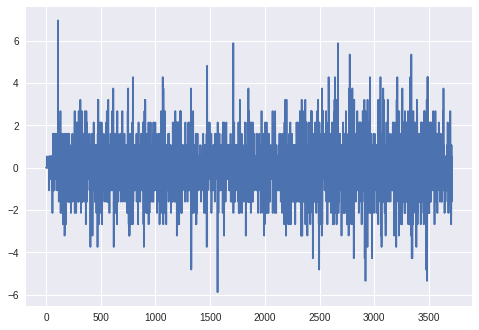

In [10]:
plt.plot(Xt[2050:])

## Double check stationarity by ACF and PACF

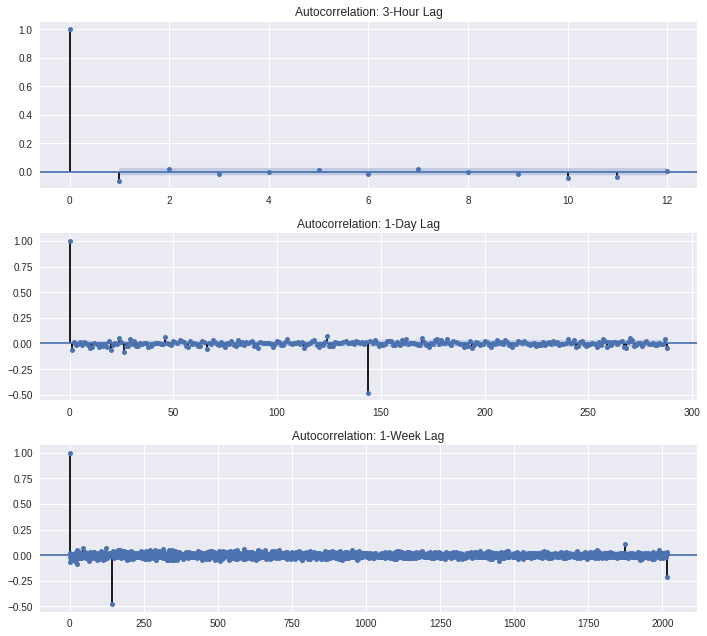

In [273]:
period_minutes = 5
samples_per_hour = int(60 / period_minutes)
samples_per_day = int(24 * samples_per_hour)
samples_per_week = int(7 * samples_per_day)
    
lags = [samples_per_hour, samples_per_day, samples_per_week]
titles= ['Autocorrelation: 3-Hour Lag',
         'Autocorrelation: 1-Day Lag',
         'Autocorrelation: 1-Week Lag']

plot_multi_acf(Xt.squeeze(), lags, titles)

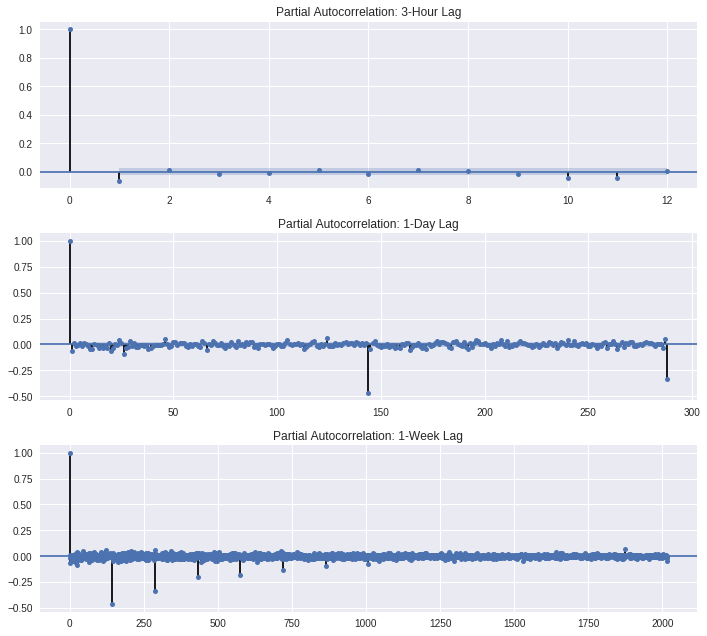

In [274]:
plot_multi_acf(Xt.squeeze(), lags, ['Partial ' + t for t in titles], 
               partial=True)

# ARIMA Model

## Fit ARIMA model with different hyper-parameters

In [0]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
pipeline = ForecasterPipeline([
    ('pre_differencer', DifferenceTransformer(period=samples_per_week)),
    ('pre_diff_imputer', ReversibleImputer()),
    ('pre_day_differencer', DifferenceTransformer(period=samples_per_day)),
    ('pre_day_diff_imputer', ReversibleImputer()),
    ('pre_scaler', StandardScaler()),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=1)),
        ('seasonal_features', SeasonalTransformer(seasonal_period=samples_per_hour)),#12
        ('seasonal_features1', SeasonalTransformer(seasonal_period=samples_per_day)),#288
        ('seasonal_features2', SeasonalTransformer(seasonal_period=144)),
        ('seasonal_features3', SeasonalTransformer(seasonal_period=532)),
        ('seasonal_features4', SeasonalTransformer(seasonal_period=676))
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('post_feature_scaler', StandardScaler()),
    ('regressor', LinearRegression(fit_intercept=False))
])

pipeline = pipeline.fit(X, y_sample)

## Make prediction and plot the fitted value

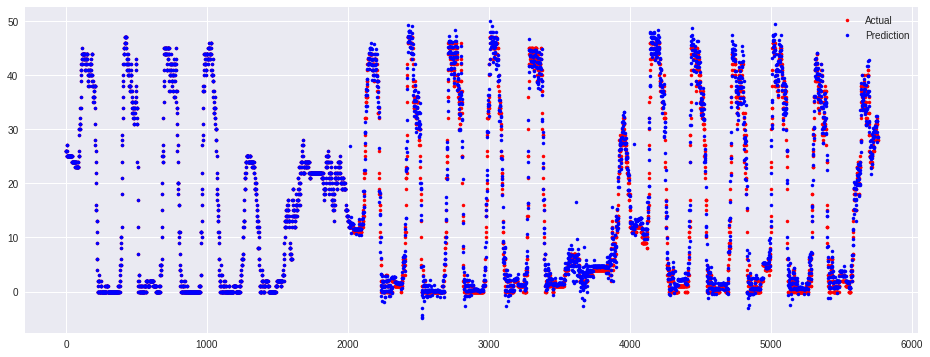

In [21]:
plt.figure(figsize = (16,6))
plt.plot(y_sample.values, 'r.')
plt.plot(pipeline.predict(X, to_scale=True), 'b.')
plt.legend(['Actual', 'Prediction'])

## 

In [17]:
np.round(pipeline.named_steps["regressor"].coef_,2)

array([ 0.96,  0.01, -0.03,  0.01, -0.  , -0.01])

In [0]:
resid = y_sample.values-pipeline.predict(X, to_scale=True)
plt.plot(resid)

## Out of sample forecast

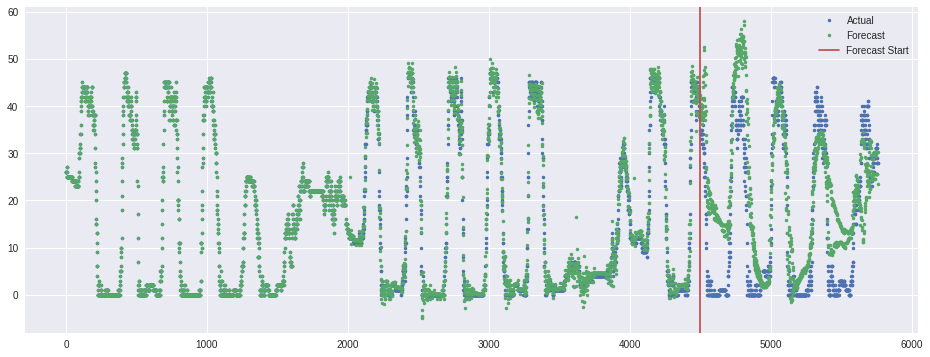

In [19]:
start_idx = 4500
plt.figure(figsize = (16,6))
plt.plot(y_sample.values, '.');
plt.plot(pipeline.forecast(X, start_idx=start_idx), '.')

ax = plt.gca()
ylim = ax.get_ylim()
plt.plot((start_idx, start_idx), ylim)
plt.ylim(ylim);
plt.legend(['Actual', 'Forecast', 'Forecast Start'])

## Train ARIMA model with different hyper-parameters

In [0]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
pipeline = ForecasterPipeline([
    ('pre_differencer', DifferenceTransformer(period=samples_per_week)),
    ('pre_diff_imputer', ReversibleImputer()),
    ('pre_day_differencer', DifferenceTransformer(period=samples_per_day)),
    ('pre_day_diff_imputer', ReversibleImputer()),
    ('pre_scaler', StandardScaler()),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=12)),
        ('seasonal_features', SeasonalTransformer(seasonal_period=144)),
        ('seasonal_features1', SeasonalTransformer(seasonal_period=288)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('post_feature_scaler', StandardScaler()),
    ('regressor', LinearRegression(fit_intercept=False))
])

pipeline = pipeline.fit(X, y_sample)

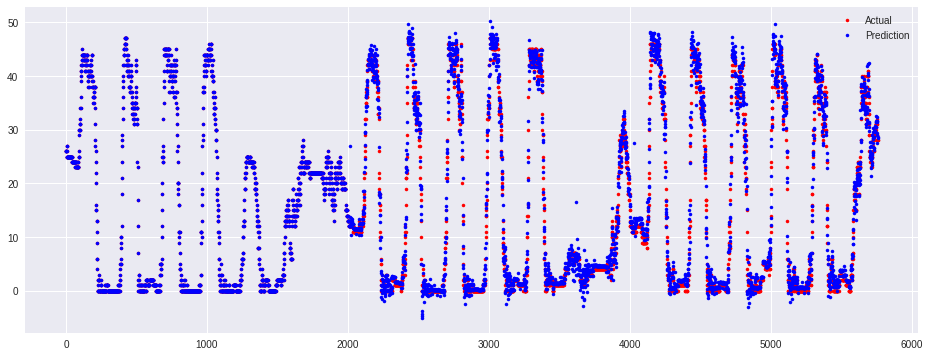

In [26]:
plt.figure(figsize = (16,6))
plt.plot(y_sample.values, 'r.')
plt.plot(pipeline.predict(X, to_scale=True), 'b.')
plt.legend(['Actual', 'Prediction'])

## Coefficient of fitted model and RMSE

In [27]:
np.round(pipeline.named_steps["regressor"].coef_,2)

array([ 0.03,  0.03, -0.06, -0.02,  0.01,  0.03, -0.02,  0.  , -0.03,
       -0.  ,  0.12,  0.89,  0.01, -0.03])

In [30]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_sample, pipeline.predict(X, to_scale=True))
rmse = np.sqrt(mse)
print(f'RMSE = {rmse:4.2f}')

RMSE = 1.39


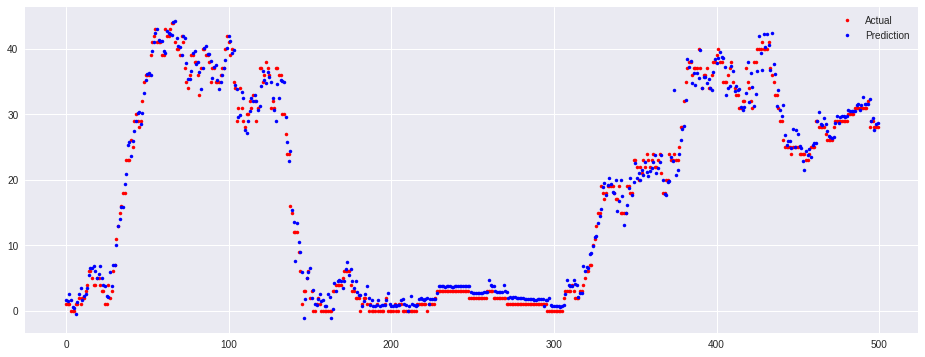

In [33]:
plt.figure(figsize = (16,6))
plt.plot(y_sample.values[-500:], 'r.')
plt.plot(pipeline.predict(X, to_scale=True)[-500:], 'b.')
plt.legend(['Actual', 'Prediction'])

## Out of sample forecast

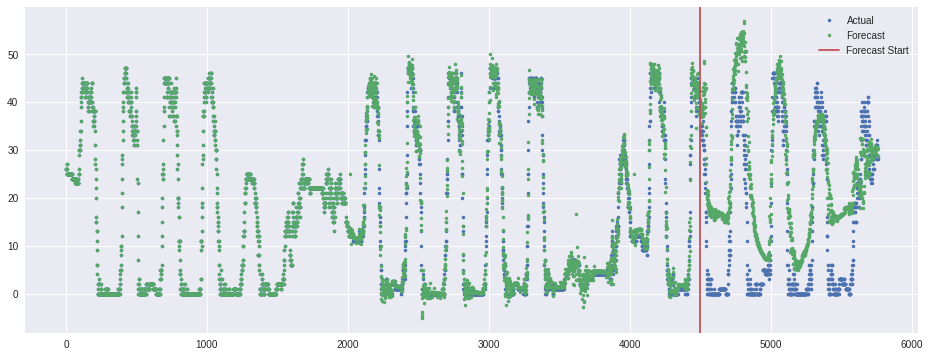

In [28]:
start_idx = 4500
plt.figure(figsize = (16,6))
plt.plot(y_sample.values, '.');
plt.plot(pipeline.forecast(X, start_idx=start_idx), '.')

ax = plt.gca()
ylim = ax.get_ylim()
plt.plot((start_idx, start_idx), ylim)
plt.ylim(ylim);
plt.legend(['Actual', 'Forecast', 'Forecast Start'])

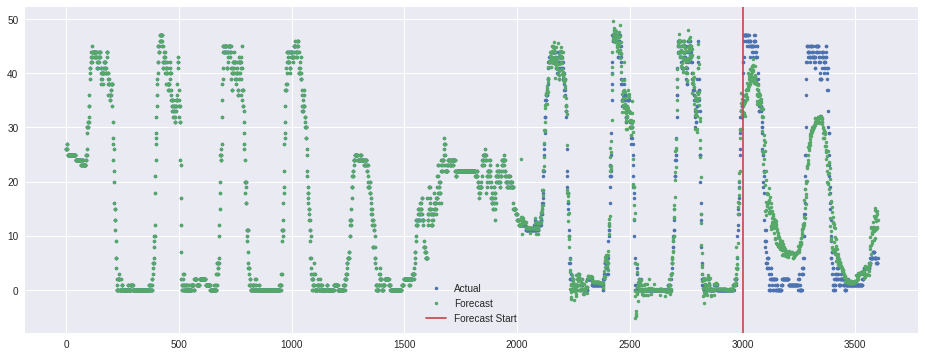

In [42]:
start_idx = 3000
plt.figure(figsize = (16,6))
plt.plot(y_sample.values[:3600], '.');
plt.plot(pipeline.forecast(X[:3600,:], start_idx=start_idx), '.')

ax = plt.gca()
ylim = ax.get_ylim()
plt.plot((start_idx, start_idx), ylim)
plt.ylim(ylim);
plt.legend(['Actual', 'Forecast', 'Forecast Start'])

# Classification Forecast

In [0]:
y_sample_bi = y_sample > 0
pipeline = ClassifierPipeline([
#     ('pre_differencer', DifferenceTransformer(period=samples_per_week)),
#     ('pre_diff_imputer', ReversibleImputer()),
#     ('pre_day_differencer', DifferenceTransformer(period=samples_per_day)),
#     ('pre_day_diff_imputer', ReversibleImputer()),
#     ('pre_scaler', StandardScaler()),
    ('features', FeatureUnion([
        ('ar_features', AutoregressiveTransformer(num_lags=12)),
    ])),
    ('post_feature_imputer', ReversibleImputer()),
    ('classifier', LogisticRegression(fit_intercept=False))
])

pipeline = pipeline.fit(X, y_sample_bi)

In [57]:
from sklearn.metrics import roc_auc_score
y_bi_pred = pipeline.predict_proba(X)[:, 1]
print('AUC = {}'.format(roc_auc_score(y_sample_bi, y_bi_pred)))

AUC = 0.9701489504684944


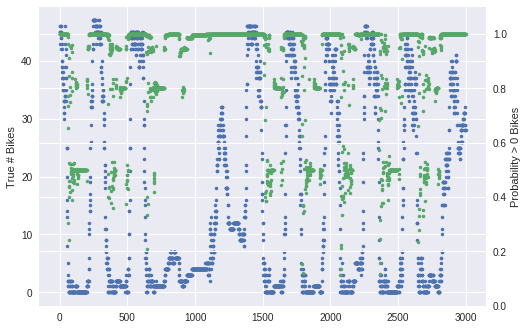

In [58]:
fig, ax = plt.subplots();
ax.plot(X[-3000:, 0], '.');
ax2 = ax.twinx();
ax2.plot(y_bi_pred[-3000:], 
         '.',
         c=ax._get_lines.get_next_color());
ax2.set_ylim((0, 1.1));

ax.set_ylabel('True # Bikes');
ax2.set_ylabel('Probability > 0 Bikes');

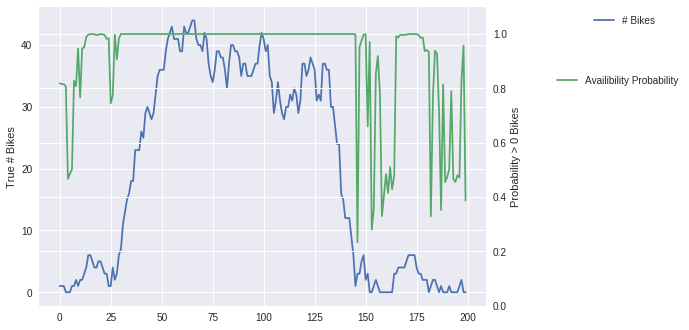

In [62]:
fig, ax = plt.subplots();
ax.plot(X[-500:-300], '-');
ax2 = ax.twinx();
ax2.plot(y_bi_pred[-500:-300], 
         '-',
         c=ax._get_lines.get_next_color());
ax2.set_ylim((0, 1.1));
ax.set_ylabel('True # Bikes');
ax2.set_ylabel('Probability > 0 Bikes');
ax.legend(['# Bikes'], bbox_to_anchor=(1.4, 1));
ax2.legend(['Availibility Probability'], bbox_to_anchor=(1.14, .8));

# LSTM model

In [82]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense

Using TensorFlow backend.


In [0]:
data = y_sample
data

In [0]:
scl = MinMaxScaler()
data = data.reshape(data.shape[0],1)
data = scl.fit_transform(data)
X,y = [],[]
    
for i in range(len(data) - 12 -1):
  X.append(data[i:(i+12)])
  y.append(data[(i+12)])
X = np.array(X)
y = np.array(y)

In [129]:
X[-1]

array([[0.65957447],
       [0.65957447],
       [0.65957447],
       [0.65957447],
       [0.65957447],
       [0.65957447],
       [0.65957447],
       [0.68085106],
       [0.59574468],
       [0.61702128],
       [0.61702128],
       [0.59574468]])

In [125]:
y[-1]

array([0.59574468])

In [0]:
p = np.concatenate((X[-1], y[-1]), axis=None)[1:]

In [132]:
p.reshape(p.shape[0],1)

array([[0.65957447],
       [0.65957447],
       [0.65957447],
       [0.65957447],
       [0.65957447],
       [0.65957447],
       [0.68085106],
       [0.59574468],
       [0.61702128],
       [0.61702128],
       [0.59574468],
       [0.59574468]])

In [0]:
class LSTM_TS(object):
  # initialize the stock data
  def __init__(self,y,window_size = 12):
    self.ts = y
    self.lb = window_size   

  def plot(self):
    plt.style.use('seaborn-notebook')
    plt.plot(self.ts,color='b',linewidth = 1)
    plt.ylabel('# Bikes')
    
  def create_LSTM_model(self,units = 64):
    
    self.model = Sequential()
    self.model.add(LSTM(units,input_shape = (self.lb,1)))
    self.model.add(Dense(1))
    
    self.model.compile(optimizer = 'adam', loss = 'mse')
  
  def __processData(self,data):
    
    X,y = [],[]
    
    for i in range(len(data) - self.lb -1):
      X.append(data[i:(i+self.lb)])
      y.append(data[(i+self.lb)])
      
    return np.array(X),np.array(y)
    
    
  def train_LSTM_model(self,epochs = 100):
    data = self.ts.values
    scl = MinMaxScaler()
    data = data.reshape(data.shape[0],1)
    data = scl.fit_transform(data)
    self.X, self.y = self.__processData(data)
    
    X_train, X_test = self.X[:int(self.X.shape[0]*0.75)], self.X[int(self.X.shape[0]*0.75):]
    y_train, y_test = self.y[:int(self.y.shape[0]*0.75)], self.y[int(self.y.shape[0]*0.75):]
    
    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
    
    print("Start training LSTM model...")
    history = self.model.fit(X_train,y_train,epochs = epochs,verbose = 0, validation_data = (X_test,y_test), shuffle = False)
    print("Training process is done.")
    
    plt.style.use('seaborn-notebook')
    plt.figure(figsize = (16,10))
    plt.subplot(2,2,1)
    plt.plot(history.history['loss'], label = "Training Loss")
    plt.plot(history.history['val_loss'], label = "Validation_Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Loss function")
    plt.legend(loc='best')
    
    train_pred = self.model.predict(X_train)
    test_pred = self.model.predict(X_test)
    
    self.train_pred  = scl.inverse_transform(train_pred)
    self.test_pred = scl.inverse_transform(test_pred)
    self.y_train = scl.inverse_transform(y_train.reshape(-1,1))
    self.y_test = scl.inverse_transform(y_test.reshape(-1,1))
    
    train_rmse = np.round(np.sqrt(mean_squared_error(self.y_train,self.train_pred)),2)
    plt.subplot(2,2,2)
    plt.plot(self.y_train,color='k',label="original series")
    plt.plot(self.train_pred,color='r',label="predicted series")
    plt.title("Prediction of # Bikes on Training Set, RMSE = {}".format(train_rmse))
    plt.legend(loc='best')
    
    test_rmse = np.round(np.sqrt(mean_squared_error(self.y_test,self.test_pred)),2)
    plt.subplot(2,2,3)
    plt.plot(self.y_test,color='k',label="original series")
    plt.plot(self.test_pred,color='r',label="predicted series")
    plt.title("Prediction of # Bikes on Test Set, RMSE = {}".format(test_rmse))
    plt.legend(loc='best')
    

  def oos_forecast(self,start_at = 3000,future = 500):
    data = self.ts.values
    scl = MinMaxScaler()
    data = data.reshape(data.shape[0],1)
    data = scl.fit_transform(data)
    
    X1 = self.X[:start_at][-1]
   
    prediction = []
    
    for i in range(future): 
      pred = self.model.predict(X1.reshape(1,self.lb,1))
      X1 = np.concatenate((X1, pred), axis=None)[1:]
      X1 = X1.reshape(X1.shape[0],1)
      pred = scl.inverse_transform(pred.reshape(1,-1))
      prediction = np.concatenate((prediction, pred), axis=None)
      
    
    plt.style.use('seaborn-notebook') 
    plt.figure(figsize = (16,6))
    plt.plot(np.arange(0,(start_at+future),1),self.ts[:(start_at+future)], 'k.',label="Observations")
    plt.plot(np.arange(self.lb,start_at,1),self.train_pred[:(start_at-self.lb)],'b.',label = 'Prediction')
    plt.plot(np.arange(start_at,start_at+future,1),prediction, 'r.',label="Out of sampel forecast")
    plt.title("Out of Sample Forecast for {} hours by Trained Model".format(np.round((future*5)/60)))
    plt.ylabel('# Bikes')
    plt.legend(loc="best")

    

In [0]:
lstm = LSTM_TS(y_sample,window_size = 288)

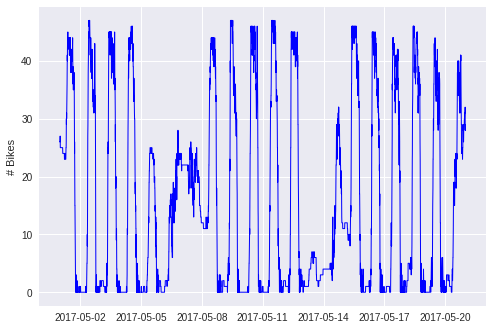

In [135]:
lstm.plot()

In [0]:
lstm.create_LSTM_model()

Start training LSTM model...
Training process is done.


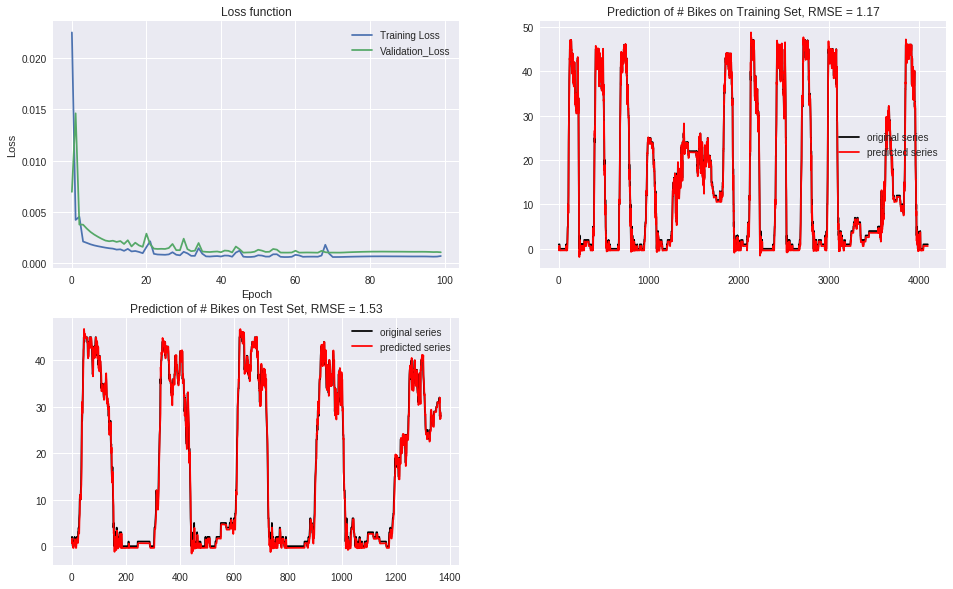

In [208]:
lstm.train_LSTM_model()

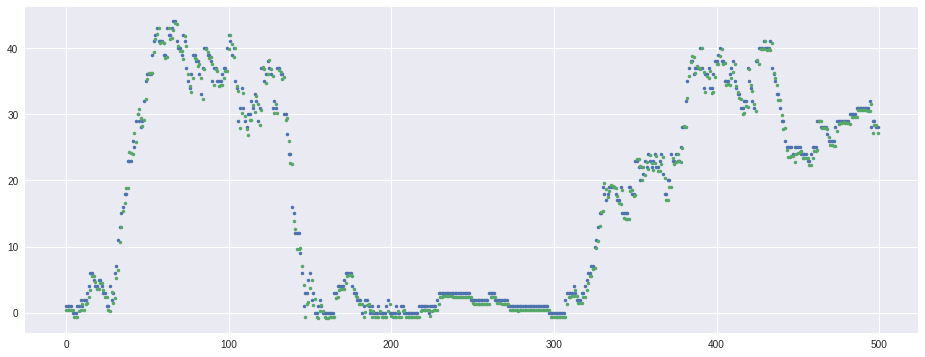

In [103]:
plt.figure(figsize=(16,6))
plt.plot(lstm.y_test[-500:],'.')
plt.plot(lstm.test_pred[-500:],'.')

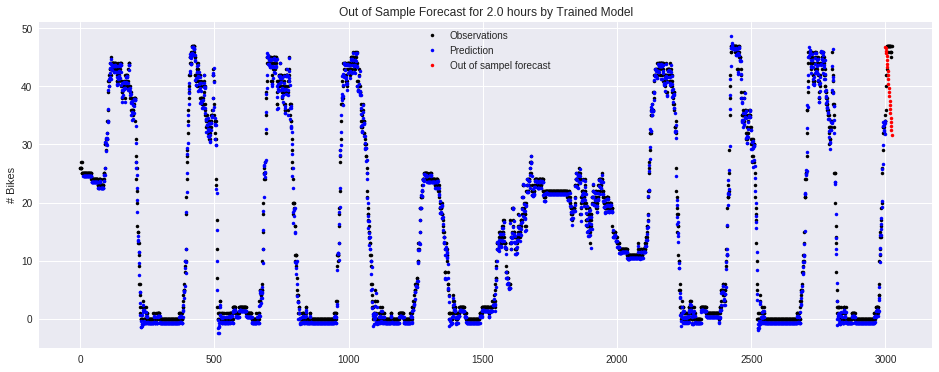

In [201]:
lstm.oos_forecast(future = 24)

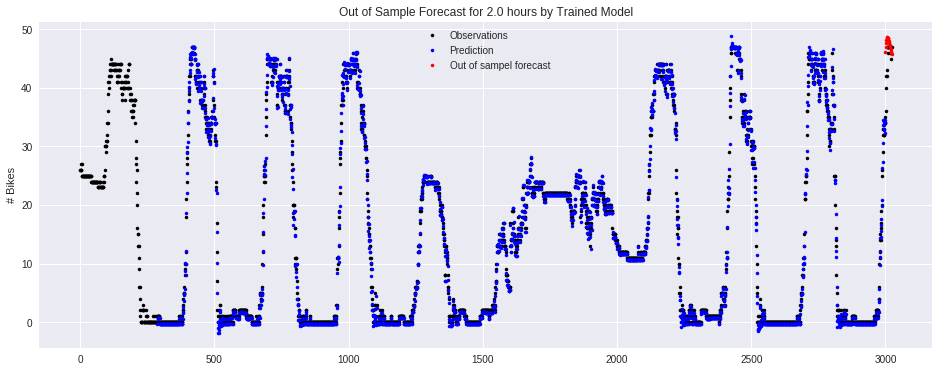

In [209]:
lstm.oos_forecast(future = 24)

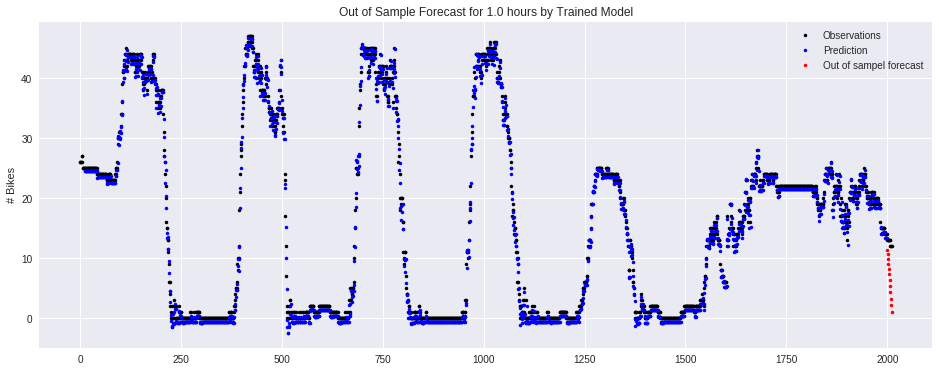

In [204]:
lstm.oos_forecast(start_at = 2000,future = 12)

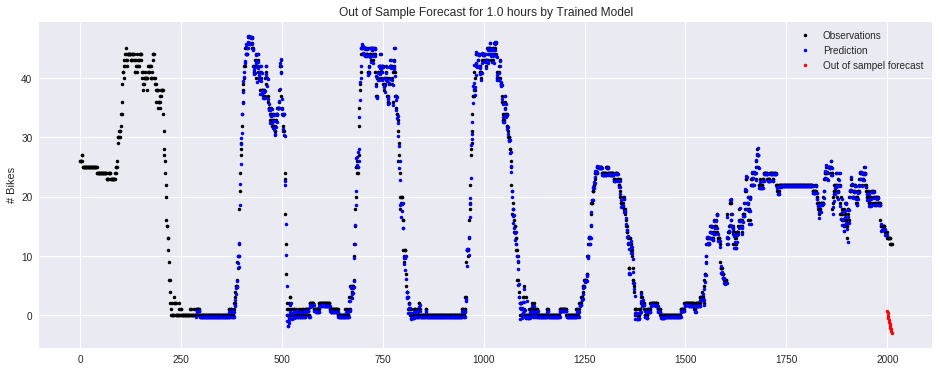

In [210]:
lstm.oos_forecast(start_at = 2000,future = 12)

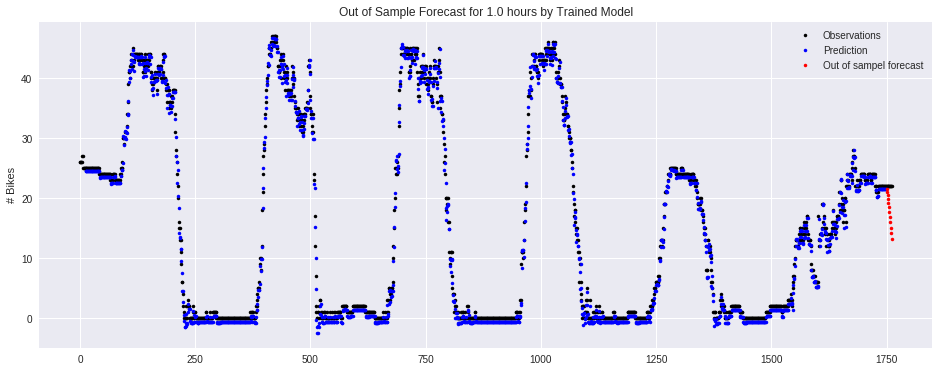

In [205]:
lstm.oos_forecast(start_at = 1750,future = 12)

# Implement ARIMA model by built-in API in python

## [Example](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)

In [59]:
import itertools
p  = range(0, 2)
q = range(1,3)
d = [1,2]

# Generate all different combinations of p, q and q triplets
pdq = [(x[0],x[1],x[2]) for x in list(itertools.product(p,d, q))]

P = Q = range(0,2)
s = [1,2,4,8,12]
D=0

seasonal_pdqs = [(x[0], 0, x[1], x[2]) for x in list(itertools.product(P, Q, s))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdqs[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdqs[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdqs[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdqs[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 2) x (0, 0, 0, 2)
SARIMAX: (0, 1, 2) x (0, 0, 0, 4)
SARIMAX: (0, 2, 1) x (0, 0, 0, 8)
SARIMAX: (0, 2, 1) x (0, 0, 0, 12)


In [0]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

model = {}
model['pdq'] = (0,1,1)
model['PDQs'] = (0,0,0,1)
model['AIC'] = np.inf

for param in pdq:
    for param_seasonal in seasonal_pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_value,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print("Training model with {} x {}, AIC = {}".format(param,param_seasonal,results.aic))
            if model['AIC'] > results.bic:
              model['pdq'] = param
              model['PDQs'] = param_seasonal
              model['AIC'] = results.aic
        except:
            continue
print("Best model with {} x {}, AIC = {}".format(model['pdq'],model['PDQs'],model['AIC']))

In [0]:
mod = sm.tsa.statespace.SARIMAX(y_sample.values,
                                order=(1, 1, 0),
                                seasonal_order=(144,288,0,1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])


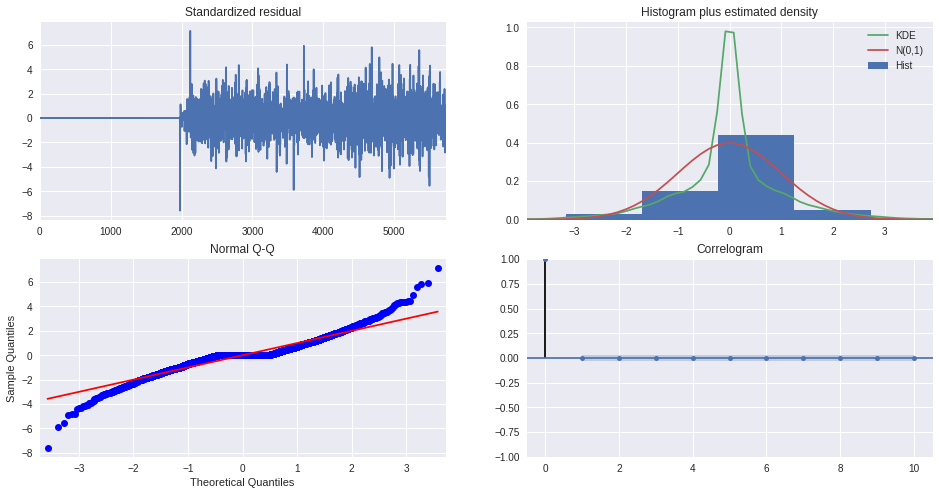

In [284]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

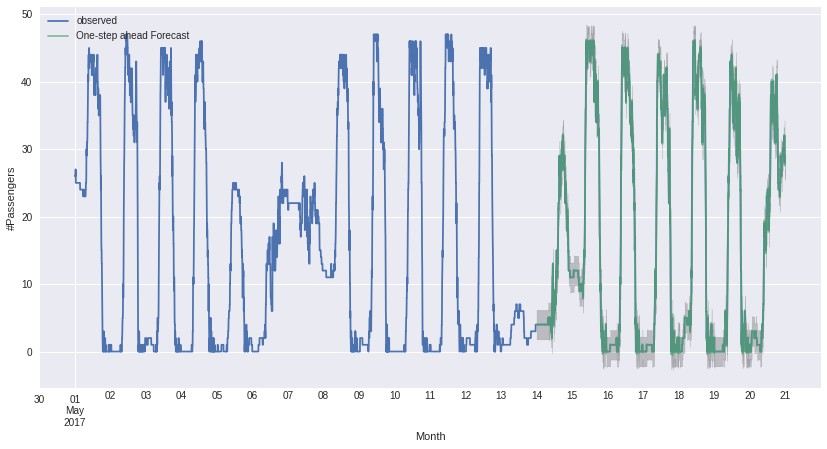

In [28]:
pred = results.get_prediction(start=pd.to_datetime('2017-05-13 23:55:00'),end = pd.to_datetime('2017-05-20 23:55:00'), dynamic=False)
pred_ci = pred.conf_int()

ax = y.loc['2017-05-01':'2017-05-20'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('#Passengers')
plt.legend()

plt.show()

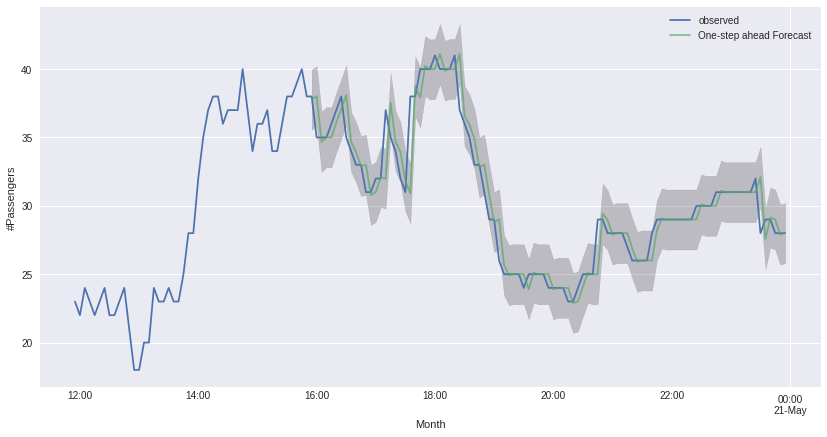

In [41]:
pred = results.get_prediction(start=pd.to_datetime('2017-05-20 15:55:00'),end = pd.to_datetime('2017-05-20 23:55:00'), dynamic=False)
pred_ci = pred.conf_int()

ax = y.loc['2017-05-20 11:55:00':'2017-05-20'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('#Passengers')
plt.legend()

plt.show()

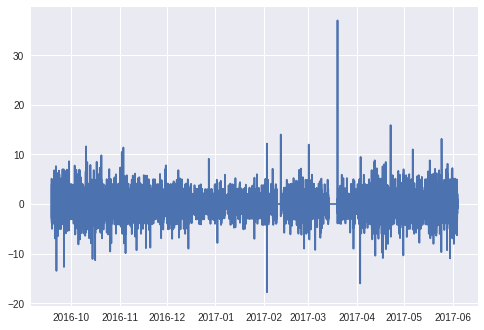

In [31]:
plt.plot(results.resid)